<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_8_Light_v2_%D0%90%D1%83%D0%B4%D0%B8%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light задание. Вариант 2
Используйте готовый ноутбук с занятия
1. Соберите обучающую и проверочную выборку (просто запуская последовательно
ячейки ноутбука)
2. Обучите полносвязную сеть
3. Сделайте совсем простую сеть - один скрытый слой и 10 нейронов
4. Сделайте сложную сеть - 5-7 слоёв по 100-1000 нейронов
5. Добавьте в сеть слои Dropout
6. Добавьте в сеть слои BatchNormalization
7. Поменяйте внутренние активационные функции, варианты - relu, elu, linear
8. Поменяйте размер batch_size - маленький, средний и большой

Во всех пунктах, где запускали сеть (пункты 2-8), напишите, какую использовали архитектуру, какая была точность на обучающей и проверочной выборках. Напишите свои выводы


In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras import utils #Для to_categorical
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков
#Отрисовка графиков в ячейках collab
%matplotlib inline 
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax #Оптимизатор для задания шага обучения
from tensorflow.keras.models import Sequential, Model #Два формата модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слови
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

#Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')
#Базу для ноутбука можно скачать по ссылке
#http://marsyas.info/downloads/datasets.html

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Занятие_8_Обработка аудиосигналов/data')

## Загружаем и параметризируем данные

In [ ]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/Занятие_8_Обработка аудиосигналов/data/genres.zip', 'r')
z.extractall()

#Задаём названия жанров
#В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
#Функция параметризации аудир
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)) #Частота цветности
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #Спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Ширина полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты
  
  #Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список
  return out

In [ ]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30)
    #Превращаем сигнал в параметризованные данныеБМ и питон ещё нет
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 107c
Жанр classical готов -> 101c
Жанр country готов -> 100c
Жанр disco готов -> 100c
Жанр hiphop готов -> 100c
Жанр jazz готов -> 102c
Жанр metal готов -> 100c
Жанр pop готов -> 99c
Жанр reggae готов -> 100c
Жанр rock готов -> 103c


In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

#Проверяем, что X_train нормировался
print(X_train[0])

[-0.35174834 -0.01072298 -0.58330334 -0.45603703 -0.48616606 -0.49196656
  0.30825241  0.70267397 -0.47208991  0.36365286 -0.42809766  0.336699
 -0.86228989  0.49955307 -0.63882728  0.40965935 -0.33793065  0.64627569
  0.18318659  0.79292112 -0.26528935 -0.08675042  0.50028721 -0.23719158
  0.00761145  0.60349813]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1, shuffle=True)

#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


## Экспериментируем с простой сетью

### Сделайте совсем простую сеть - один скрытый слой и 10 нейронов

In [ ]:
len(indexes)
X_train.shape[1]

26

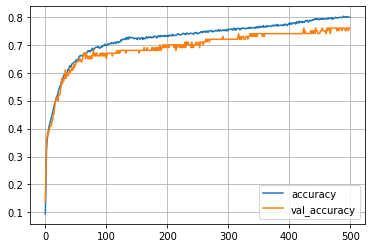

In [ ]:
#Доля данных, используемых для обучения
indexes = range(0, 26)

input = Input(shape=(X_train.shape[1]))
x = Dense(256, activation = 'elu')(input)
x = Dense(10, activation='softmax')(x)

model = Model(input, x)

#Компилируем сеть
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, min_lr=1e-07, verbose = 1)

#Обучаем
history = model.fit(X_train[:, indexes], y_train,
                    epochs = 500, batch_size = 30, verbose = 0,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

### Добавьте в сеть слои Dropout


Epoch 00083: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 8.100000122794882e-05.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 6.56100019114092e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 5.904900172026828e-05.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 5.314410154824145e-05.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 4.7829690083744934e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 4.304672074795235e-05.


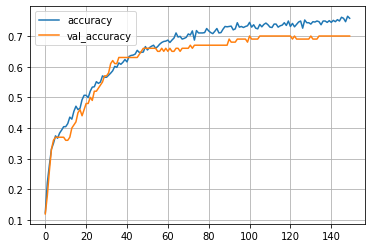

In [ ]:
#Доля данных, используемых для обучения
indexes = range(0, 26)

input = Input(shape=(X_train.shape[1]))
x = Dense(256, activation = 'relu')(input)
x = Dropout(0.1)(x)
x = Dense(10, activation='softmax')(x)

model = Model(input, x)

#Компилируем сеть
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=3, min_lr=1e-07, verbose = 1)

#Обучаем
history = model.fit(X_train[:, indexes], y_train,
                    epochs = 500, batch_size = 30, verbose = 0,
                    validation_data=(X_test[:, indexes], y_test),
                    callbacks = [early_stopping, reduce_lr])

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

### Добавьте в сеть слои BatchNormalization


Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


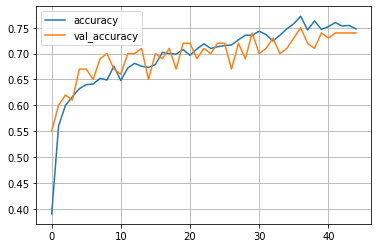

In [ ]:
#Доля данных, используемых для обучения
indexes = range(0, 26)

input = Input(shape=(X_train.shape[1]))
x = Dense(256, activation = 'elu')(input)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model = Model(input, x)

#Компилируем сеть
model.compile(optimizer=Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-07, verbose = 1)

#Обучаем
history = model.fit(X_train[:, indexes], y_train,
                    epochs = 500, batch_size = 30, verbose = 0,
                    validation_data=(X_test[:, indexes], y_test),
                    callbacks = [early_stopping, reduce_lr])

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

## Сделайте сложную сеть - 5-7 слоёв по 100-1000 нейронов

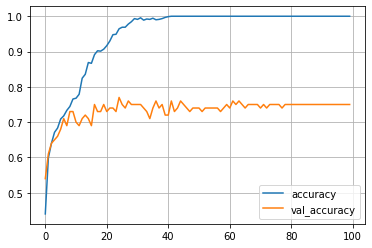

In [ ]:
#Доля данных, используемых для обучения
indexes = range(0, 26)

input = Input(shape=(X_train.shape[1]))
x = Dense(256*8, activation = 'elu')(input)
#x = BatchNormalization()(x)
#x = Dropout(0.1)(x)
x = Dense(256*8, activation = 'elu')(x)
#x = Dropout(0.1)(x)
x = Dense(256*8, activation = 'elu')(x)
#x = Dropout(0.1)(x)
x = Dense(256, activation = 'elu')(x)
x = Dense(256, activation = 'elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input, x)

#Компилируем сеть
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-06, verbose = 1)

#Обучаем
history = model.fit(X_train[:, indexes], y_train,
                    epochs = 100, batch_size = 30, verbose = 0,
                    validation_data=(X_test[:, indexes], y_test),
                    callbacks = [early_stopping, reduce_lr])

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

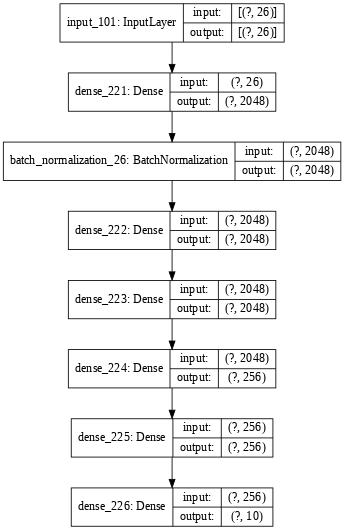

In [ ]:
plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

### Другой вариант

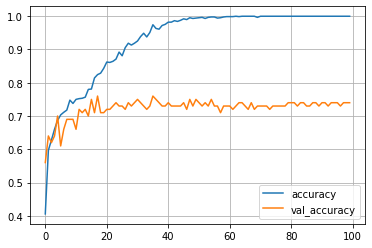

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

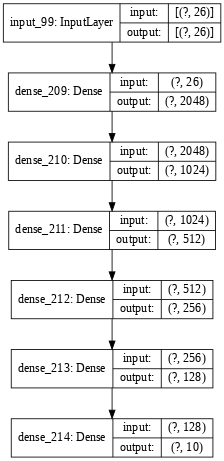

In [ ]:
plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

# Выводы:
-----
1. Dropout, как и ожидалось увеличил "пилу"в обучении. Пришлось поставить callback замедления скорость чтобы ее сгладить. Но без него было лучше
2. BatchNormalization пилу увеличил, пришлось поиграть скоростью.. результат улучшился. 
Трудно сказать что из них сработает в конкретном случае..
3. Активаторы, кроме linear работают примерно все одинаково.. отношу это на то, что простая сеть или особенности подачи данных
4. Большой batch_size ухудшает качество обучения. И ранее тоже..

---
Более сложжная сеть: увеличение числа слоев Dense позволила быстрее достичь цели, но не дало лучший результат

5. В итоге точность удалось достичь не более 0.75

